=== STEER Framework Initialization ===
STEER version: Custom (Dev)
PyTorch version: 2.8.0+cu128

Target Input: /nvme/users/liuzhy/Review_Files/1_Simulation/simulation_data/bilinear.h5ad
Output Directory: /nvme/users/liuzhy/Review_Files/1_Simulation/simulation_results/Model_Demo/bilinear_demo
Hardware utilized: cuda:0

>>> Step 1: Data Loading & Preprocessing...
Normalized count data: X, spliced, unspliced.
Logarithmized X.


/nvme/users/liuzhy/miniconda3/envs/steer/lib/python3.10/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)

>>> Step 2: Executing Model Pre-training...
Epoch 0, Loss 11.95889663696289
Epoch 50, Loss 0.20928344130516052
Epoch 100, Loss 0.1217617467045784
Epoch 150, Loss 0.10632316023111343
Epoch 200, Loss 0.09194046258926392
Epoch 250, Loss 0.0857771784067154
Epoch 300, Loss 0.08206208050251007
Epoch 350, Loss 0.07951502501964569
Epoch 400, Loss 0.0773438811302185
Epoch 450, Loss 0.07561977207660675
Epoch 500, Loss 0.9862126708030701
Epoch 550, Loss 0.297926127910614
Epoch 600, Loss 0.23163893818855286
Epoch 650, Loss 0.22126153111457825


R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |                                                                      |   0%

/nvme/users/liuzhy/miniconda3/envs/steer/lib/python3.10/site-packages/rpy2/robjects/numpy2ri.py:241: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '


  |======================================================================| 100%
Initial clustering via 'mclust' applied successfully.

>>> Step 3: Deriving Kinetic Priors...
--- Task 1: Generating Fine Clusters (Method: hierarchical) ---
  -> Hierarchical K-Means: Target size 300
  -> Generated 11 hierarchical micro-clusters.
--- Task 2: Gene Filtering Skipped (Calculated on expert_cluster for reference) ---
--- Task 3: Calculating Direction (Based on: FINE_CLUSTER) ---
Starting parallel processing with n_jobs=-1...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 128 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 346 out of 500 | elapsed:   16.9s remaining:    7.5s
[Parallel(n_jobs=-1)]: Done 447 out of 500 | elapsed:   18.4s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   19.2s finished


Aggregating results...
Done.
--- Finalizing: Restoring Expert labels & Preparing Fine Cluster Vector ---
Prior kinetic geometry and fine-grained clusters successfully computed.

>>> Step 4: Fine-Tuning with Guided Priors...
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Using Fine Cluster Vector for Correlation Loss.
Epoch 0, Loss 11.95889663696289
Epoch 50, Loss 0.2053392082452774
Epoch 100, Loss 0.12834714353084564
Epoch 150, Loss 0.10594241321086884
Epoch 200, Loss 0.1102328822016716
Epoch 250, Loss 0.0858878642320633
Epoch 300, Loss 0.08206802606582642
Epoch 350, Loss 0.07936142385005951
Epoch 400, Loss 0.07728122919797897
Epoch 450, Loss 0.07556262612342834
Epoch 500, Loss 0.9893625974655151
Epoch 550, Loss 0.27815085649490356
Epoch 600, Loss 0.21669505536556244
Epoch 650, Loss 0.21078644692897797
Epoch 700, Loss 0.20828743278980255
Epoch 750, Loss 1.1677172183990479
GATE: 0.06175896897

  0%|          | 0/3000 [00:00<?, ?cells/s]

    finished (0:00:05) --> added 
    'pred_vs_norm_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'pred_vs_norm_spatial', embedded velocity vectors (adata.obsm)


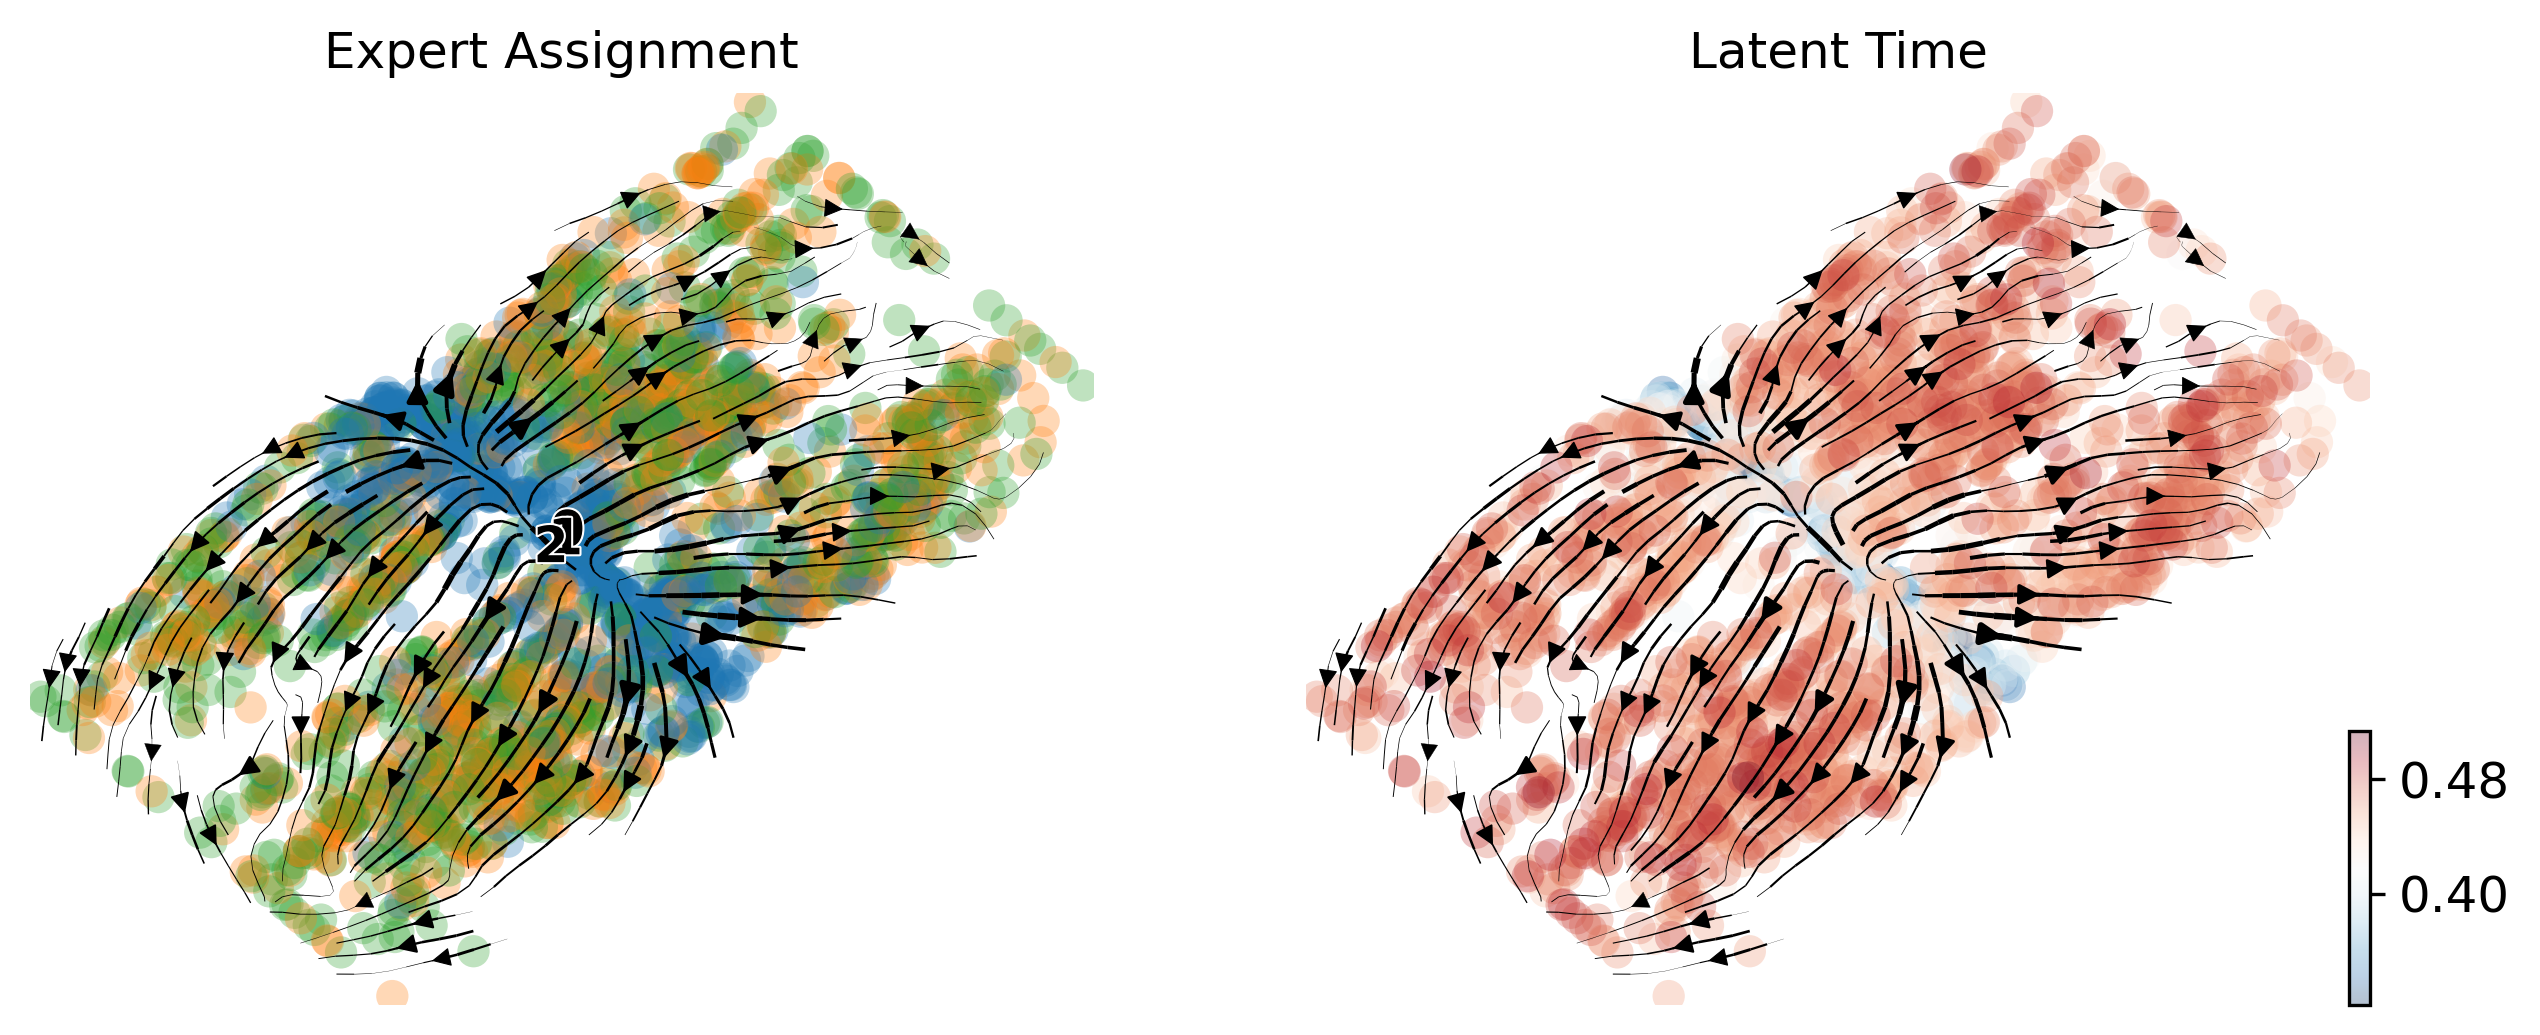


✅ STEER pipeline successfully executed!
CPU times: user 10min 5s, sys: 1min 8s, total: 11min 13s
Wall time: 2min 55s


In [1]:
%%time
import os
import sys
import random
import warnings

# Import core libraries
import torch
import torch.backends.cudnn as cudnn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scanpy as sc
import scvelo as scv

import steer
from steer.prior.prior import PriorInferenceManager

# Suppress standard warnings
warnings.filterwarnings('ignore')
%matplotlib inline

print(f"=== STEER Framework Initialization ===")
print(f"STEER version: {steer.__version__ if hasattr(steer, '__version__') else 'Custom (Dev)'}")
print(f"PyTorch version: {torch.__version__}")
print("======================================\n")

# ==============================================================================
# 1. Configuration & Hyperparameters
# ==============================================================================
class Config:
    # --- Data & Paths ---
    data_name = 'bilinear'
    input_dir = "./data/"
    result_dir = "./results/"
    seed = 2026
    
    # --- Model Architecture ---
    expert = 3                 # Number of kinetic experts (clusters)
    smooth_neigh = 30          # Number of neighbors for smoothing
    spatial_neighbors = 8      # Number of spatial neighbors
    npc = 30                   # Number of principal components
    
    # --- Training Control ---
    pretrain_epochs = 500
    finetune_epochs = 5000     # Will be regulated by Early Stopping
    
    # --- Advanced Settings ---
    graph = "union"            
    corr_mode = "u"            
    neighbor_metric = "cosine" 
    use_us = True              
    use_filter = False         
    fine_method = "hierarchical" 
    target_size = 300          
    
cfg = Config()

INPUT_FILE = os.path.join(cfg.input_dir, f"{cfg.data_name}.h5ad")
RESULT_PATH = os.path.join(cfg.result_dir, f"{cfg.data_name}_demo")
os.makedirs(RESULT_PATH, exist_ok=True)

print(f"Target Input: {INPUT_FILE}")
print(f"Output Directory: {RESULT_PATH}")

def setup_seed(seed):
    """Ensure reproducibility across numpy and torch environments."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

setup_seed(cfg.seed)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Hardware utilized: {device}\n")

# ==============================================================================
# 2. Data Loading & Preprocessing
# ==============================================================================
print(">>> Step 1: Data Loading & Preprocessing...")
adata = sc.read_h5ad(INPUT_FILE)

# Basic filtering and normalization
scv.pp.filter_and_normalize(adata, min_shared_counts=None, n_top_genes=None, enforce=True)

# Graph construction and moment calculation
df, adjacency_matrix, adata = steer.preprocess_anndata_spatial(
    adata, 
    npc=cfg.npc,
    NUM_AD_NEIGH=30,
    spatial_neighbors=cfg.spatial_neighbors,
    SMOOTH_NEIGH=cfg.smooth_neigh,
    moments_adj=True,
    combine_mode=cfg.graph,
    neighbor_metric=cfg.neighbor_metric,
    spatial_key='X_spatial',
    use_us=cfg.use_us
)

# Prepare PyTorch Geometric datasets
dataset = steer.preload_datasets_all_genes_anndata(df=df, MODEL_MODE='pretrain', adata=adata)
pyg_data = steer.create_pyg_data(dataset, adjacency_matrix, normalize=True)

# ==============================================================================
# 3. Model Pre-training Phase
# ==============================================================================
print("\n>>> Step 2: Executing Model Pre-training...")

result_adata = steer.model_training_share_neighbor_adata(
    device=device, device2=device,
    pyg_data=pyg_data, 
    MODEL_MODE='pretrain', 
    adata=adata, 
    NUM_LOSS_NEIGH=30, 
    corr_mode=cfg.corr_mode, 
    max_n_cluster=cfg.expert, 
    expert_mode='slim',
    pretrain_epochs=cfg.pretrain_epochs,
    cluster_epochs=200,
    path=RESULT_PATH
)

# Apply mclust for initial clustering
try:
    result_adata = steer.mclust_R(result_adata, num_cluster=cfg.expert)
    print("Initial clustering via 'mclust' applied successfully.")
except Exception as e:
    print("Note: 'mclust' skipped. Ensure R and rpy2 are installed for advanced clustering.")
torch.cuda.empty_cache()

# ==============================================================================
# 4. Prior Inference Phase
# ==============================================================================
print("\n>>> Step 3: Deriving Kinetic Priors...")

prior_manager = PriorInferenceManager(result_adata, df, RESULT_PATH, seed=cfg.seed)
prior_manager.task1_define_fine_clusters(method=cfg.fine_method, target_size=cfg.target_size)
prior_manager.task2_filter_genes(based_on="expert", keep_ngene=1000, use_filter=cfg.use_filter)
prior_manager.task3_calc_convexity(based_on="fine_cluster")
result_adata, df_updated, fine_clus_vec_np = prior_manager.finalize_for_training()
print("Prior kinetic geometry and fine-grained clusters successfully computed.")

# ==============================================================================
# 5. Model Fine-Tuning Phase
# ==============================================================================
print("\n>>> Step 4: Fine-Tuning with Guided Priors...")

# Extract subset of genes and inject prior information
prior_adata = result_adata.copy()
velo_adata = adata[:, prior_adata.var['is_velocity_gene']].copy()

velo_adata.layers['pred_cell_type'] = prior_adata.layers['pred_cell_type']
velo_adata.obsm['X_pre_embed'] = prior_adata.obsm['X_pre_embed']
velo_adata.obs['pred_cluster'] = prior_adata.obs['pred_cluster'].astype(int)

# Re-run preprocessing

df_fine, adjacency_matrix_fine, velo_adata = steer.preprocess_anndata_spatial(
    velo_adata, npc=cfg.npc, NUM_AD_NEIGH=30, spatial_neighbors=cfg.spatial_neighbors,
    SMOOTH_NEIGH=cfg.smooth_neigh, moments_adj=True, neighbor_metric=cfg.neighbor_metric,
    combine_mode=cfg.graph, spatial_key='X_spatial', use_us=cfg.use_us
)

dataset_fine = steer.preload_datasets_all_genes_anndata(df=df_fine, MODEL_MODE='whole', adata=velo_adata)
pyg_data_fine = steer.create_pyg_data(dataset_fine, adjacency_matrix_fine, normalize=True)
pyg_data_fine.fine_clus_vec = torch.tensor(fine_clus_vec_np, dtype=torch.long, device=device)

# Execute Fine-tuning
velo_adata = steer.model_training_share_neighbor_adata(
    device=device, device2=device,
    pyg_data=pyg_data_fine, 
    MODEL_MODE='whole', 
    adata=velo_adata, 
    NUM_LOSS_NEIGH=30, 
    max_n_cluster=cfg.expert,
    corr_mode=cfg.corr_mode, 
    pretrain_epochs=500,
    cluster_epochs=200,
    velo_batch_size=512,
    MIN_IMPRO=0.01, PATIENCE=100, # Early stopping logic
    num_epochs=cfg.finetune_epochs,
    path=RESULT_PATH
)
print("Fine-tuning completed (Early Stopping triggered).")

# ==============================================================================
# 6. Post-processing & Visualization
# ==============================================================================
print("\n>>> Step 5: Constructing Velocity Vector Fields...")

result_adata = velo_adata.copy()
result_adata = steer.normalize_l2_anndata(result_adata, layer_vu='pred_vu', layer_vs='pred_vs')
result_adata = steer.clean_anndata(result_adata)

sc.pp.neighbors(result_adata, use_rep='X_refine_embed', n_neighbors=100)

steer.velocity_graph(result_adata, vkey='pred_vs_norm', xkey='model_Ms')

# Standardize visualization layout
scv.settings.figdir = RESULT_PATH
scv.set_figure_params(style='scvelo', dpi=150, figsize=(5, 4), transparent=True)

scv.pl.velocity_embedding_stream(
    result_adata, basis='spatial', vkey='pred_vs_norm', 
    color=['Expert', 'Pred Time'], title=['Expert Assignment', 'Latent Time'], show=True
)

print("\n✅ STEER pipeline successfully executed!")